[View in Colaboratory](https://colab.research.google.com/github/zacqoo/tf_shark_detector_colab/blob/master/tf_shark_detector_colab.ipynb)

**0. Re-start Kernel**

In [0]:
# restart Kernel
!kill -9 -1

**1. Install packages and setup tensorflow object detection testing**

In [1]:
# checking what files in current directory
!ls

sample_data


In [0]:
!apt-get install -y -qq protobuf-compiler python-pil python-lxml

In [0]:
# clone tensorflow models
!git clone --quiet https://github.com/tensorflow/models.git

In [0]:
!apt-get install -qq protobuf-compiler python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install -q pycocotools

In [0]:
import os
os.chdir('models/research')

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import sys
sys.path.append('/content/models/research/slim')

In [0]:
# test to see if tensorflow model works; Ran 18 tests in 0.177s
%run object_detection/builders/model_builder_test.py

In [0]:
# checking what files in current directory
# note: should have "object_detection" folder
!ls

**2. Download and extract image dataset**

In [10]:
from google.colab import files
files.upload()
# choose the file "label_map.pbtxt" to upload

Saving label_map.pbtxt to label_map.pbtxt


{u'label_map.pbtxt': "item {\n  id: 1\n  name: 'shark'\n}"}

In [0]:
# check what files we have; should have "label_map.pbtxt"
!ls

To get a Google Drive file Id
From Google Drive web, right click on file, then click Get shareable link. 
Last part of the link is file Id. Then you can cancel the sharing.
See [here](https://stackoverflow.com/questions/15057907/how-to-get-the-file-id-so-i-can-perform-a-download-of-a-file-from-google-drive-a/48855034#48855034)

In [0]:
#Substitute fileId value with your dataset.zip id in Google Drive.
fileId = '11Ti5fA1dnAskjJu6F8a4vGLV0_ejymFJ'

In [12]:
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

W1019 11:02:52.873570 140066703075200 _default.py:280] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Extracted zip file 11Ti5fA1dnAskjJu6F8a4vGLV0_ejymFJ.zip


In [0]:
image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

**3. Empty png files**

In [14]:
# Create empty png mask files to avoid error in create_pet_tf_record.py
# they are not used in training model.
%cd  annotations

!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (500, 300))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

/content/models/research/annotations


In [15]:
# go back to the previous layer
%cd ..

/content/models/research


**4. Create TFRecord**

In [16]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md
%run object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record
!mv pet_faces_val.record-00000-of-00001 tf_val.record

object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [0]:
# check what files we have; should have "tf_train.record" and "tf_val.record"
!ls

In [0]:
#from google.colab import files
#files.download('tf_train.record')

In [0]:
#from google.colab import files
#files.download('tf_val.record')

**5. Download pretrained model**

Downloads faster_rcnn_inception_v2_coco model to use as starting checkpoint. To use another model from ModelZoo change MODEL var.

In [0]:
import os
import shutil
import glob
import urllib
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
#MODEL = 'ssd_mobilenet_v1_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [0]:
# check what files we have; should have "pretrained_model" folder
!ls

**6. Edit model config file**

In [0]:
import re

filename = 'object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
#filename = 'object_detection/samples/configs/ssd_mobilenet_v1_coco.config'

with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', 'pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', 'tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', 'tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', 'label_map.pbtxt', s)
  
  #s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', 'pretrained_model/model.ckpt', s)
  #s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record-\?\?\?\?\?-of-00100', 'tf_train.record', s)
  #s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record-\?\?\?\?\?-of-00010', 'tf_val.record', s)
  #s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', 'label_map.pbtxt', s)
  f.write(s)

In [0]:
# create model_dir for storing trained models
!mkdir -p model_dir

In [0]:
#!rm -rf model_dir

**7. Training**

In [0]:
%run object_detection/model_main.py \
    --pipeline_config_path=object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --model_dir=model_dir \
    --alsologtostderr \
    --num_train_steps=9000 \
    --num_eval_steps=1500

In [0]:
#@title save data to drive
filename = "model_dir" #@param {type:"string"}
folders_or_files_to_save = "model_dir" #@param {type:"string"}
from google.colab import files
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

def save_file_to_drive(name, path):
    file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
    }

    media = MediaFileUpload(path, 
                  mimetype='application/octet-stream',
                  resumable=True)

    created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created


extension_zip = ".zip"

zip_file = filename + extension_zip

# !rm -rf $zip_file
!zip -r $zip_file {folders_or_files_to_save} # FOLDERS TO SAVE INTO ZIP FILE

auth.authenticate_user()
drive_service = build('drive', 'v3')

destination_name = zip_file
path_to_file = zip_file
save_file_to_drive(destination_name, path_to_file)


**8. Export trained model**

In [0]:
# create new folder for storing export
!mkdir -p fine_tuned_model

In [0]:
lst = os.listdir('model_dir')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

In [0]:
last_model

'model.ckpt-9000'

In [0]:
####Delete all flags before declare#####

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
      FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

In [0]:
%run object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=model_dir/model.ckpt-9000 \

In [0]:
#@title save data to drive
filename = "fine_tuned_model" #@param {type:"string"}
folders_or_files_to_save = "fine_tuned_model" #@param {type:"string"}
from google.colab import files
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

def save_file_to_drive(name, path):
    file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
    }

    media = MediaFileUpload(path, 
                  mimetype='application/octet-stream',
                  resumable=True)

    created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created


extension_zip = ".zip"

zip_file = filename + extension_zip

# !rm -rf $zip_file
!zip -r $zip_file {folders_or_files_to_save} # FOLDERS TO SAVE INTO ZIP FILE

auth.authenticate_user()
drive_service = build('drive', 'v3')

destination_name = zip_file
path_to_file = zip_file
save_file_to_drive(destination_name, path_to_file)


**9. Upload image for inference, testing**

In [0]:
# create new folder for uploading test images
!mkdir -p test_images

In [0]:
%cd test_images

/content/models/research/test_images


In [0]:
from google.colab import files
files.upload()
# choose test images to upload to the folder
#import data

Saving image4.jpg to image4.jpg


{u'image4.jpg': '\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xfe\x00\x1ccmp3.10.3.3Lq3 0x96925d63\x00\xff\xdb\x00C\x00\x03\x01\x01\x01\x01\x01\x03\x01\x01\x01\x03\x03\x03\x02\x02\x07\x05\x02\x02\x02\x02\t\x03\x07\x05\x07\x0b\t\x0b\x0b\x05\t\n\n\x0b\r\x10\x0e\x0b\x0c\x0f\r\n\n\x0e\x14\x0e\x0f\x11\x12\x12\x12\x12\x0b\x0e\x14\x16\x14\x12\x16\x10\x12\x12\x12\xff\xdb\x00C\x01\x01\x01\x01\x02\x02\x02\x04\x02\x02\x04\x08\x05\x04\x05\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\xff\xc0\x00\x11\x08\x01M\x01\xf4\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x02\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x01\x04\x00\x05\x06\x07\x08\t\xff\xc4\x00V\x10\x00\x01\x02\x04\x02\x05\x08\x05\x08\x06\x07\x04\n\x02\x03\x00\x02\x01\x03\x00\x04\x05\x12\x06\x11\x07\x13!"1\x08\x14#2ABQRabqr\x81\t\x1

In [0]:
%cd ..

/content/models/research


**10. Run Inference**

In [0]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
CWD_PATH = os.getcwd()

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(CWD_PATH, 'object_detection', 'data', 'mscoco_label_map.pbtxt')

In [0]:
NUM_CLASSES = 1

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [0]:
# First test on images# First 
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 5) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

((650, 432), (432, 650, 3))
((500, 334), (334, 500, 3))
((500, 375), (375, 500, 3))
((500, 333), (333, 500, 3))


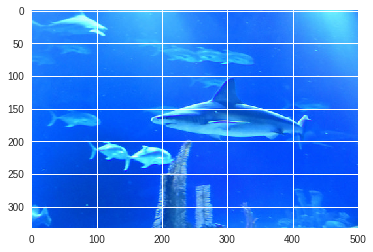

In [0]:
from matplotlib import pyplot as plt
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

In [0]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [0]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)

**11. Processing videos**

Detect shark in the video

In [0]:
# install moviepy package
!pip install moviepy

In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [0]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_process = detect_objects(image, sess, detection_graph)
            return image_process

In [0]:
from google.colab import files
files.upload()
# choose the video file to upload
#import data

Saving video1.mp4 to video1.mp4


In [0]:
white_output = 'video1_out.mp4'
clip1 = VideoFileClip("video1.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output, audio=False)

In [0]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [0]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
clip = VideoFileClip("video1_out.mp4")
clip.write_videofile("video1_box.mp4",bitrate="5000k")

In [0]:
from google.colab import files
files.download('video1_box.mp4')